In [1]:
#ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error as MSE
%matplotlib inline

# データの読み込み
data = pd.read_csv('train.tsv', sep='\t')
data = data.drop(columns='id')
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,29.0,4,135.0,84.0,2525.0,16.0,82,1,dodge aries se
1,31.9,4,89.0,71.0,1925.0,14.0,79,2,vw rabbit custom
2,19.0,6,156.0,108.0,2930.0,15.5,76,3,toyota mark ii
3,28.0,4,90.0,75.0,2125.0,14.5,74,1,dodge colt
4,37.7,4,89.0,62.0,2050.0,17.3,81,3,toyota tercel


In [2]:
# データの型確認
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           199 non-null    float64
 1   cylinders     199 non-null    int64  
 2   displacement  199 non-null    float64
 3   horsepower    199 non-null    object 
 4   weight        199 non-null    float64
 5   acceleration  199 non-null    float64
 6   model year    199 non-null    int64  
 7   origin        199 non-null    int64  
 8   car name      199 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 14.1+ KB


In [3]:
# horsepowerをfloatに変換
data['horsepower'] = pd.to_numeric(data['horsepower'], 'coerce')

# 主観分析

count    199.000000
mean      24.307035
std        7.797665
min        9.000000
25%       18.000000
50%       24.000000
75%       30.500000
max       44.600000
Name: mpg, dtype: float64
Skewness:0.31749240931027956
Kurtosis:-0.6226056613814079


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


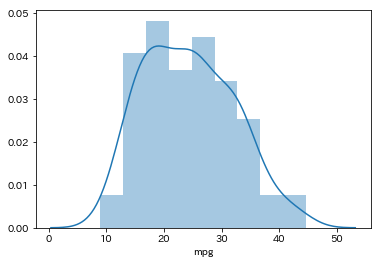

In [4]:
# 目的変数の確認
print(data['mpg'].describe())

# 目的変数のhistgram
sns.distplot(data['mpg'])

# 歪度と尖度
print("Skewness:{}".format(data['mpg'].skew()))
print("Kurtosis:{}".format(data['mpg'].kurt()))

Text(0, 0.5, 'mpg')

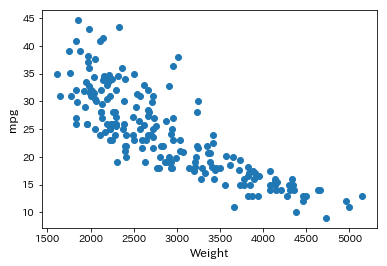

In [5]:
# weightとmpgの相関
plt.scatter(x=data['weight'],y=data['mpg'])
plt.xlabel('Weight', size=12)
plt.ylabel('mpg', size=12)

* やっぱり負の相関がある。指数的に減少している。

# 質的変数を確認する

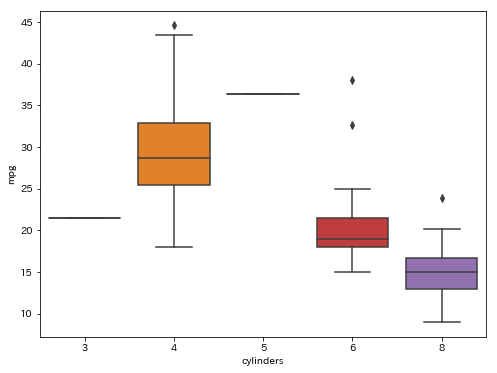

In [6]:
# 1.cylinderの数は?
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x=data['cylinders'], y=data['mpg'], data=data)

* sylindersの数はmpgと相関がありそう。sylindersの数5,6ってデータもある？

In [7]:
# 一応確認
data[data['cylinders'].isin([3,5])]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
135,36.4,5,121.0,67.0,2950.0,19.9,80,2,audi 5000s (diesel)
171,21.5,3,80.0,110.0,2720.0,13.5,77,3,mazda rx-4


* 2行しかないのでcylinders5と3は削除でいいかも

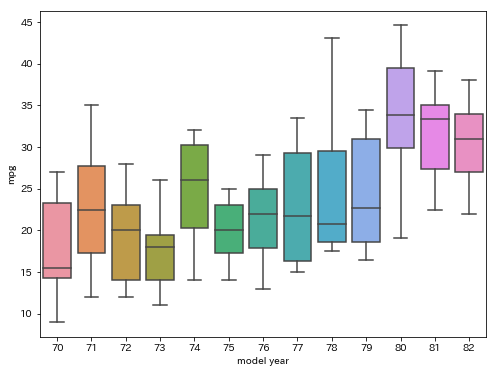

In [8]:
# 2.model yearはどう？
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x=data['model year'], y=data['mpg'], data=data)

* Gr1:70-73, Gr2:74-79, Gr3:80-

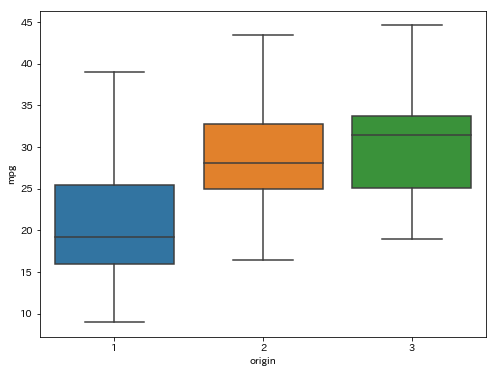

In [9]:
# 3.origin
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x=data['origin'], y=data['mpg'], data=data)

これも相関がありそう。ただしoriginって何かググってもよくわからない。

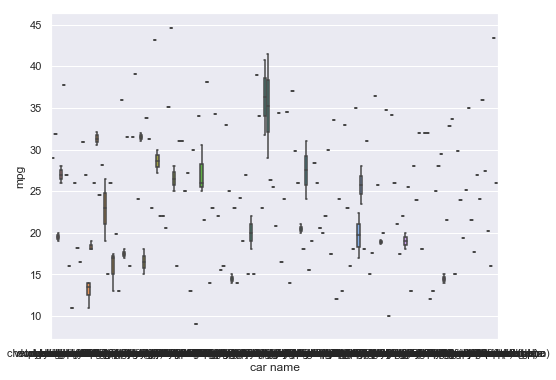

In [33]:
# 4.carname
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x=data['car name'], y=data['mpg'], data=data)

これはいいか。

# 客観的な分析

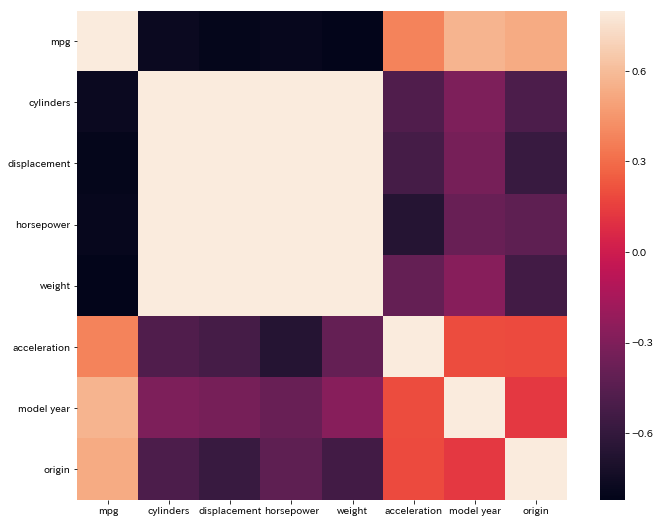

In [10]:
# 相関図
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8, square=True)

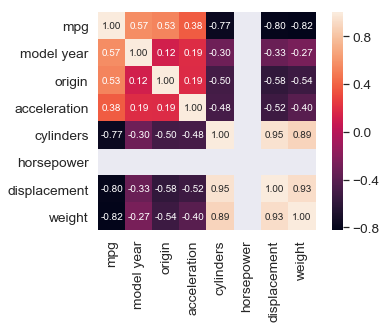

In [11]:
# 目的変数との相関図
k = 10
cols = corrmat.nlargest(k, 'mpg')['mpg'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values,
                xticklabels=cols.values)

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


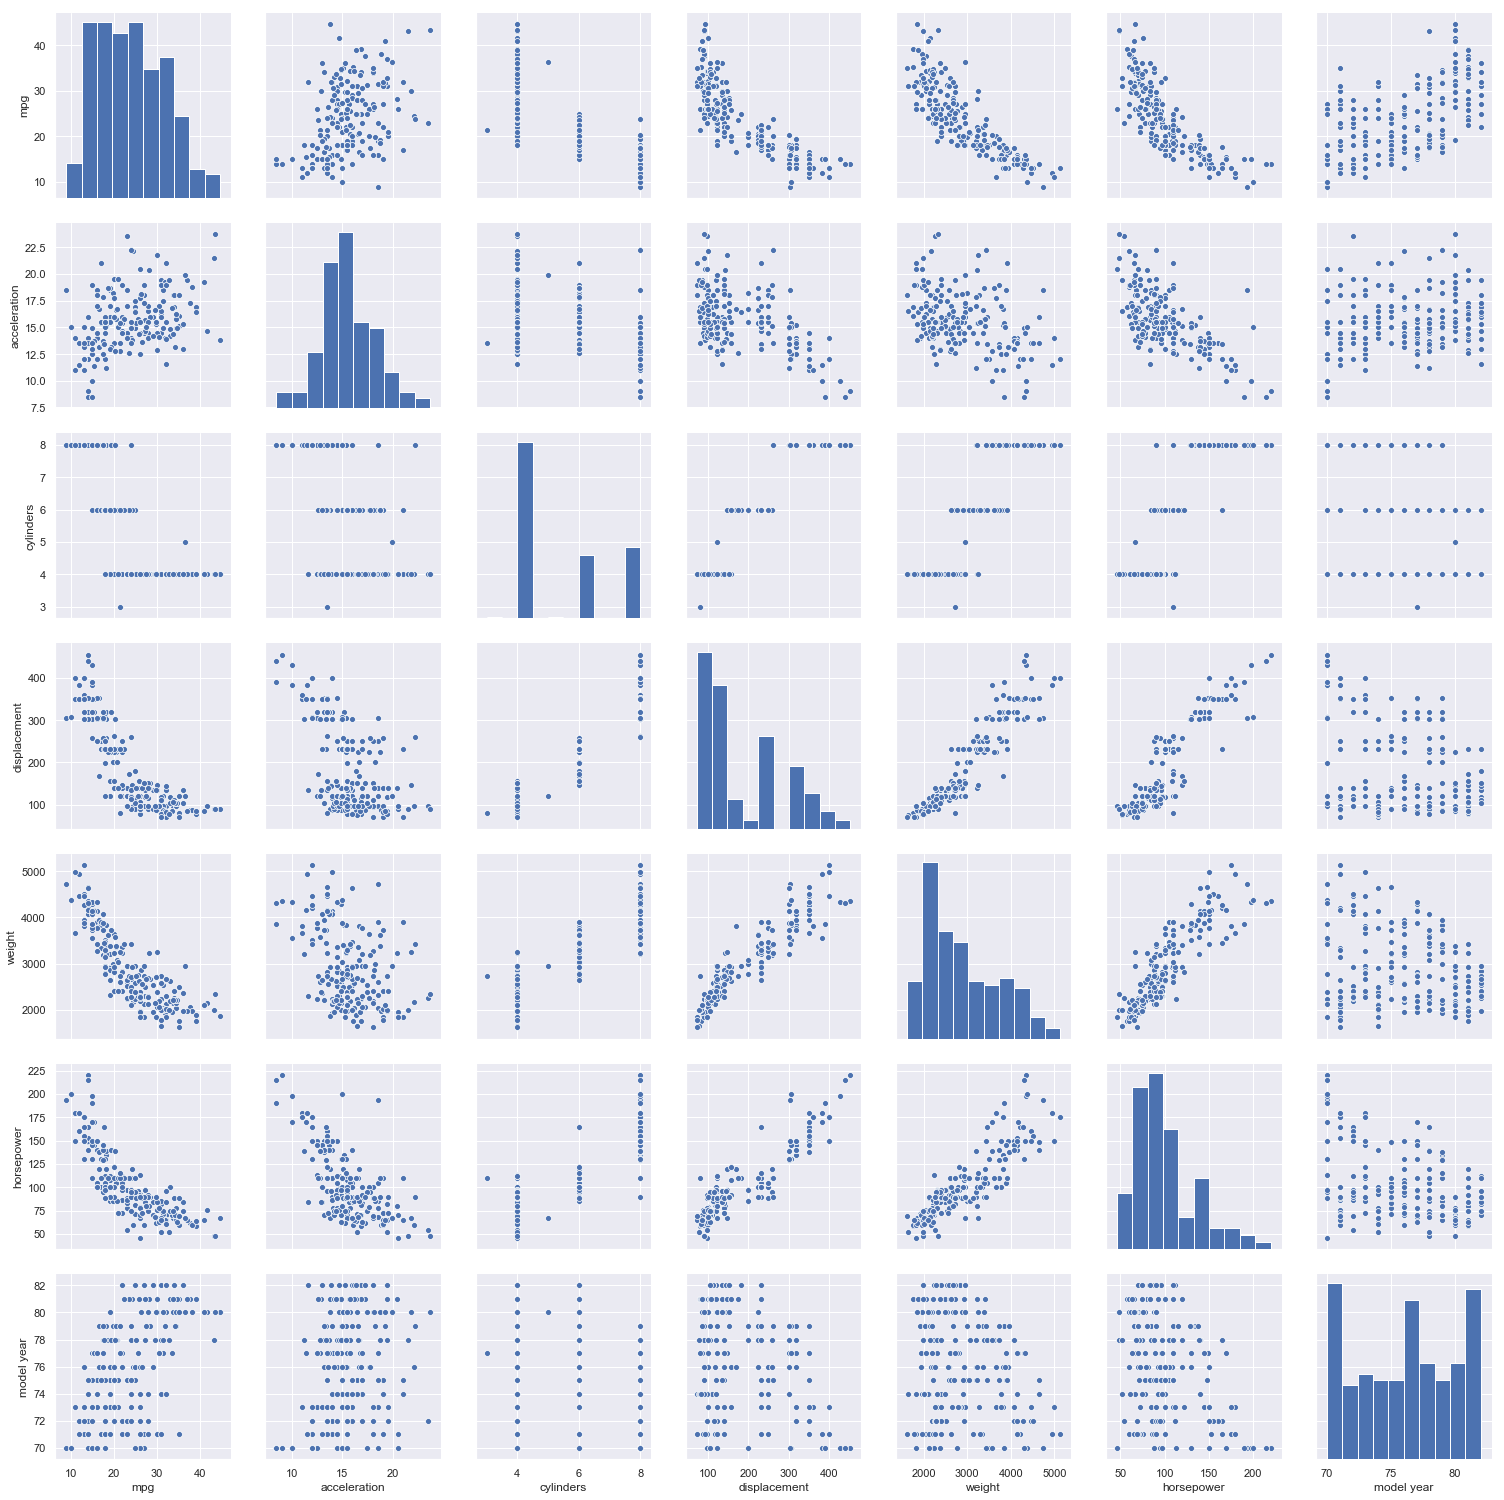

In [26]:
# 散布図
sns.set()
cols = ['mpg', 'acceleration', 'cylinders', 'displacement',
        'weight', 'horsepower', 'model year']
sns.pairplot(data[cols],size=3)

* accelerationはmpgと相関はないので、いらないかも
* cylindersとweightとdisplacementとhorsepowerは相関が高い。共相関を起こしているかも？
 * 事実：cylindersの数が多いとdisplacement(排気量)が大きくなる
 * いまいち車の事わからんのでこれ以上は何とも言えず。

# 欠損値の確認

In [13]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
horsepower,4,0.020101
mpg,0,0.000000
cylinders,0,0.000000
displacement,0,0.000000
weight,0,0.000000
acceleration,0,0.000000
model year,0,0.000000
origin,0,0.000000
car name,0,0.000000


In [14]:
# horsepowerの欠損値だけ削除する
data = data.drop(data.loc[data['horsepower'].isnull()].index)
data.isnull().sum().max()

0

In [15]:
data.shape

(195, 9)

# 外れ値の確認

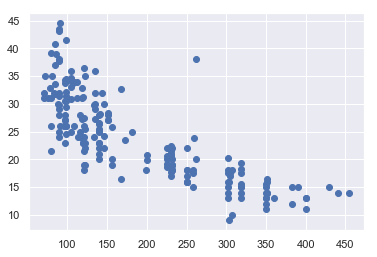

In [16]:
# diplacementの外れ値を消したい
plt.scatter(x=data['displacement'], y=data['mpg'])

In [17]:
data.sort_values(by='mpg', ascending = False)[:10]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
49,44.6,4,91.0,67.0,1850.0,13.8,80,3,honda civic 1500 gl
197,43.4,4,90.0,48.0,2335.0,23.7,80,2,vw dasher (diesel)
40,43.1,4,90.0,48.0,1985.0,21.5,78,2,volkswagen rabbit custom diesel
123,41.5,4,98.0,76.0,2144.0,14.7,80,2,vw rabbit
194,40.8,4,85.0,65.0,2110.0,19.2,80,3,datsun 210
33,39.1,4,79.0,58.0,1755.0,16.9,81,3,toyota starlet
85,39.0,4,86.0,64.0,1875.0,16.4,81,1,plymouth champ
62,38.1,4,89.0,60.0,1968.0,18.8,80,3,toyota corolla tercel
29,38.0,6,262.0,85.0,3015.0,17.0,82,1,oldsmobile cutlass ciera (diesel)
4,37.7,4,89.0,62.0,2050.0,17.3,81,3,toyota tercel


* 29行目が燃費がめっぽう悪い。これは削除する

In [18]:
data = data.drop(29)

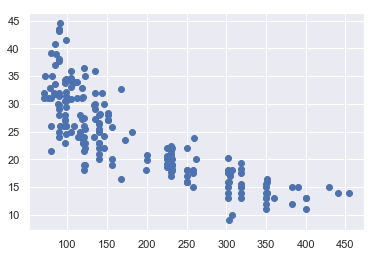

In [19]:
# diplacementの外れ値消えた？
plt.scatter(x=data['displacement'], y=data['mpg'])

* 無事消えた

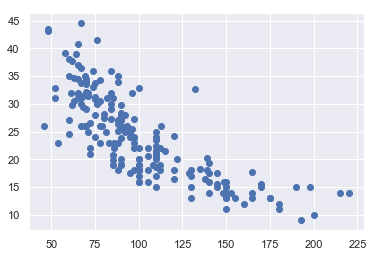

In [20]:
# 次、horsepower
plt.scatter(x=data['horsepower'], y=data['mpg'])

* horsepowerが130あたりに異様に燃費悪いデータがある。これを消したい

In [21]:
data[data['horsepower'] > 125].sort_values(by='mpg',ascending=False)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
19,32.7,6,168.0,132.0,2910.0,11.4,80,3,datsun 280-zx
195,20.2,8,302.0,139.0,3570.0,12.8,78,1,mercury monarch ghia
178,19.4,8,318.0,140.0,3735.0,13.2,78,1,dodge diplomat
9,18.2,8,318.0,135.0,3830.0,15.2,79,1,dodge st. regis
130,18.1,8,302.0,139.0,3205.0,11.2,78,1,ford futura
83,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
183,17.7,6,231.0,165.0,3445.0,13.4,78,1,buick regal sport coupe (turbo)
133,17.6,8,302.0,129.0,3725.0,13.4,79,1,ford ltd landau
182,17.5,8,305.0,145.0,3880.0,12.5,77,1,chevrolet caprice classic
148,17.5,8,318.0,140.0,4080.0,13.7,78,1,dodge magnum xe


* 19行目だ

In [22]:
data = data.drop(19)

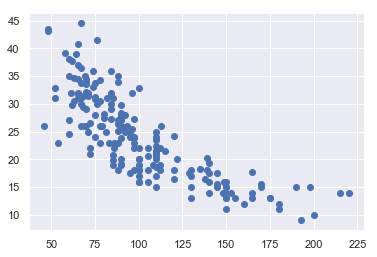

In [23]:
# もう一回確認
plt.scatter(x=data['horsepower'], y=data['mpg'])

# 対数変換
相関図でmpgはdisplacement, horsepower, weightに対し指数的に減少しているので対数変換しておく

In [24]:
data['displacement_log'] = np.log(data['displacement'])
data['horsepower_log'] = np.log(data['horsepower'])
data['weight_log'] = np.log(data['weight'])

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


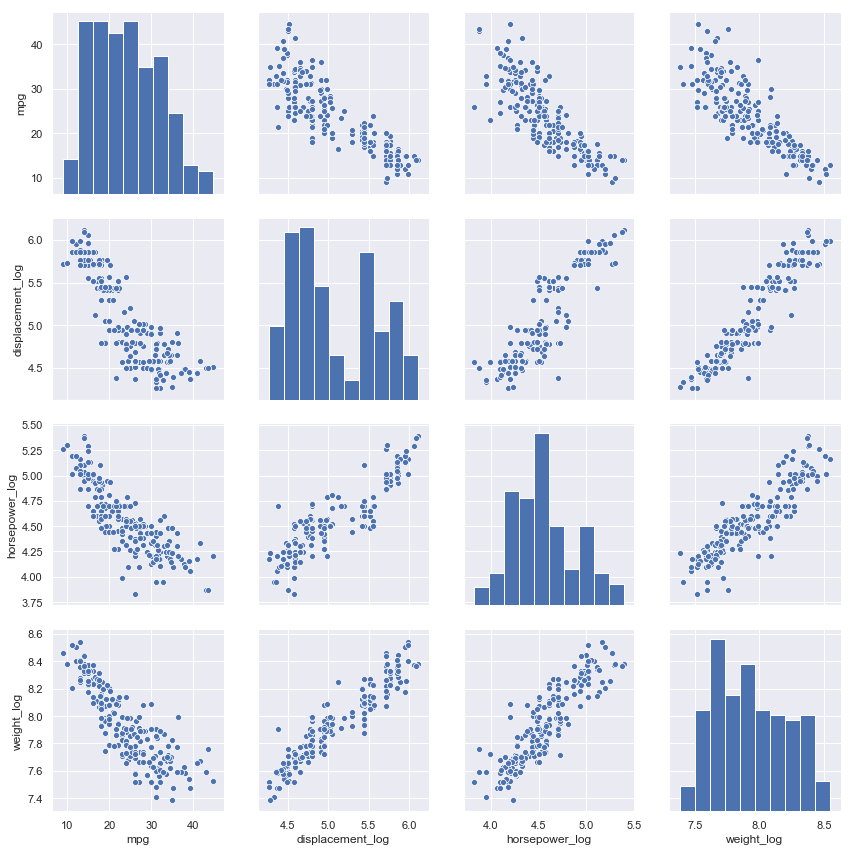

In [25]:
# 散布図確認
sns.set()
cols = ['mpg', 'displacement_log', 'horsepower_log', 'weight_log']
sns.pairplot(data[cols],size=3)

良い感じに直線のグラフが描けた

# 一旦今の時点で相関係数の高い説明変数を確認しておく

In [31]:
data.corr().sort_values(by='mpg')

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,displacement_log,horsepower_log,weight_log
displacement_log,-0.847009,0.933445,0.979972,0.869635,0.936265,-0.491581,-0.289584,-0.641124,1.000000,0.883567,0.944692
weight_log,-0.841560,0.878816,0.921768,0.861850,0.991005,-0.399238,-0.242765,-0.568924,0.944692,0.882712,1.000000
horsepower_log,-0.832790,0.841866,0.886903,0.981021,0.879554,-0.668117,-0.357436,-0.461248,0.883567,1.000000,0.882712
weight,-0.832430,0.895377,0.934062,0.874807,1.000000,-0.404260,-0.273559,-0.545212,0.936265,0.879554,0.991005
displacement,-0.823273,0.951730,1.000000,0.901275,0.934062,-0.530302,-0.339502,-0.587671,0.979972,0.886903,0.921768
horsepower,-0.803330,0.853559,0.901275,1.000000,0.874807,-0.659797,-0.390029,-0.436672,0.869635,0.981021,0.861850
cylinders,-0.789815,1.000000,0.951730,0.853559,0.895377,-0.475316,-0.309252,-0.511812,0.933445,0.841866,0.878816
acceleration,0.396047,-0.475316,-0.530302,-0.659797,-0.404260,1.000000,0.198921,0.221902,-0.491581,-0.668117,-0.399238
origin,0.543050,-0.511812,-0.587671,-0.436672,-0.545212,0.221902,0.120208,1.000000,-0.641124,-0.461248,-0.568924
model year,0.561072,-0.309252,-0.339502,-0.390029,-0.273559,0.198921,1.000000,0.120208,-0.289584,-0.357436,-0.242765


* displacement_log, weight_log, horsepower_log, cylindersが良さげ。
* ->とりあえずこの４つでモデル作成して見る

# 重回帰モデル作成

In [32]:
y = data['mpg']
X = data[['displacement_log', 'weight_log', 'horsepower_log', 'cylinders']]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

lr = LR()
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

mse_train = MSE(y_pred_train, y_train)
mse_test = MSE(y_pred_test, y_test)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

print('Train RMSE:{}'.format(rmse_train))
print('Test RMSE:{}'.format(rmse_test))

Train RMSE:3.681288153765182
Test RMSE:4.248465779107751


あまり結果がよくない。上位スコアは概ね2.7前後。。。

# 重回帰モデル2
originとmodel_yearも入れてみる

In [45]:
y = data['mpg']
X = data[['displacement_log', 'weight_log', 'horsepower_log', 'cylinders', 'origin', 'model year']]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

lr = LR()
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

mse_train = MSE(y_pred_train, y_train)
mse_test = MSE(y_pred_test, y_test)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

print('Train RMSE:{}'.format(rmse_train))
print('Test RMSE:{}'.format(rmse_test))

Train RMSE:3.0394284885625242
Test RMSE:3.5333461006630427


* 大分スコアが上がった。
* origin, model yearにはさらに見直す余地があるのでは？

# origin見直し

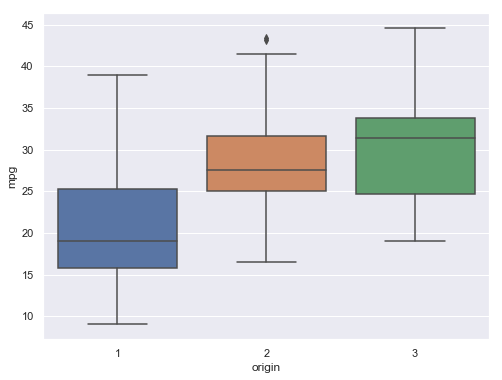

In [47]:
# originのboxplot
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x=data['origin'], y=data['mpg'], data=data)

* originが量的変数になっているので質的変数にしてみる
  (originの値に意味はないと思っている)

In [48]:
data['origin_str'] = data['origin'].astype(str)

# model yearの見直し

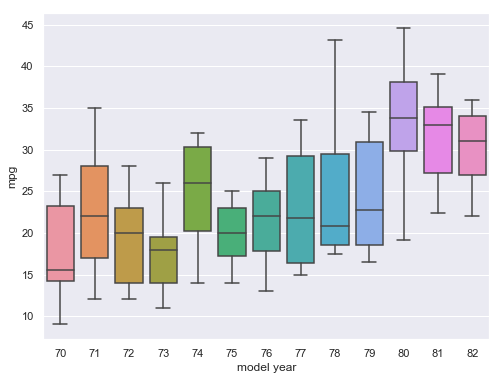

In [50]:
# model yearのboxplot
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x=data['model year'], y=data['mpg'], data=data)

70年代はヨコヨコな気もするので、70年代と80年代に分けて見てはどうだろう？

In [51]:
data['Age'] = data['model year'].apply(lambda x: '70年代' if x < 80 else '80年代')

In [52]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,displacement_log,horsepower_log,weight_log,origin_str,Age
0,29.0,4,135.0,84.0,2525.0,16.0,82,1,dodge aries se,4.905275,4.430817,7.833996,1,80年代
1,31.9,4,89.0,71.0,1925.0,14.0,79,2,vw rabbit custom,4.488636,4.262680,7.562681,2,70年代
2,19.0,6,156.0,108.0,2930.0,15.5,76,3,toyota mark ii,5.049856,4.682131,7.982758,3,70年代
3,28.0,4,90.0,75.0,2125.0,14.5,74,1,dodge colt,4.499810,4.317488,7.661527,1,70年代
4,37.7,4,89.0,62.0,2050.0,17.3,81,3,toyota tercel,4.488636,4.127134,7.625595,3,80年代


# 重回帰モデル3
* 今作ったAgeとorigin_strを説明変数に追加

In [56]:
y = data['mpg']
X = data[['displacement_log', 'weight_log', 'horsepower_log', 'cylinders', 'origin_str', 'Age']]
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

lr = LR()
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

mse_train = MSE(y_pred_train, y_train)
mse_test = MSE(y_pred_test, y_test)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

print('Train RMSE:{}'.format(rmse_train))
print('Test RMSE:{}'.format(rmse_test))

Train RMSE:2.8325079079694304
Test RMSE:2.784648775075877


-> うぉおおビンゴだ。とりあえず今回はこれで行く。

# SIGNATE提出用コード

In [84]:
test_data = pd.read_csv('test.tsv', sep='\t')
# horsepowerをfloatに変換
test_data['horsepower'] = pd.to_numeric(data['horsepower'], 'coerce')

In [85]:
# horsepowerの欠損値だけ削除する
test_data = test_data.drop(test_data.loc[test_data['horsepower'].isnull()].index)
test_data.isnull().sum().max()

0

In [86]:
test_data['displacement_log'] = np.log(test_data['displacement'])
test_data['horsepower_log'] = np.log(test_data['horsepower'])
test_data['weight_log'] = np.log(test_data['weight'])

In [87]:
test_data['origin_str'] = test_data['origin'].astype(str)
test_data['Age'] = test_data['model year'].apply(lambda x: '70年代' if x < 80 else '80年代')

In [88]:
X = test_data[['displacement_log', 'weight_log', 'horsepower_log', 'cylinders', 'origin_str', 'Age']]
X = pd.get_dummies(X)
y_pred_test = lr.predict(X)

In [89]:
test_data['mpg'] = y_pred_test

In [90]:
test_data[['id','mpg']].to_csv('./submit.csv', header=False, index=False)

# これで終わりと思ったら
* 提出ができない id33がありませんってエラーがでる。欠損値を消したことが原因のよう。
* ルール上、欠損値は消してはいけないらしい。
* horsepowerはdisplacement, cylinders, acceleration, weightと相関がある。これでモデルを作って欠損値を埋めよう。

In [91]:
horseX = test_data[['displacement', 'weight', 'cylinders', 'acceleration']]
horsey = test_data['horsepower']
lr2 = LR()
lr2.fit(horseX,horsey)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [111]:
test_data = pd.read_csv('test.tsv', sep='\t')
# horsepowerをfloatに変換
test_data['horsepower'] = pd.to_numeric(data['horsepower'], 'coerce')

In [112]:
nan_horse_data = test_data[test_data['horsepower'].isnull()]

In [113]:
horse_X = nan_horse_data[['displacement', 'weight', 'cylinders', 'acceleration']]
horse_pred = lr2.predict(horse_X)

In [114]:
horse_pred

array([ 95.33413926, 100.03867683, 104.23810998, 101.28944692,
       104.41052348, 107.09807226])

In [115]:
nan_horse_data

,id,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
19,33,4,79.0,NaN,1950.0,19.0,74,3,datsun b210
24,49,8,350.0,NaN,4360.0,14.9,79,1,buick estate wagon (sw)
29,56,4,90.0,NaN,1937.0,14.0,75,2,volkswagen rabbit
113,223,4,98.0,NaN,2219.0,16.5,74,2,audi fox
145,294,4,97.0,NaN,2130.0,14.5,71,3,datsun pl510
175,352,4,134.0,NaN,2560.0,14.2,78,3,toyota corona


In [116]:
test_data['horsepower'][19] = 95.334
test_data['horsepower'][24] = 100.038
test_data['horsepower'][29] = 104.238
test_data['horsepower'][113] = 101.289
test_data['horsepower'][145] = 104.410
test_data['horsepower'][175] = 107.098

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid 

# 改めて評価する

In [117]:
test_data['displacement_log'] = np.log(test_data['displacement'])
test_data['horsepower_log'] = np.log(test_data['horsepower'])
test_data['weight_log'] = np.log(test_data['weight'])
test_data['origin_str'] = test_data['origin'].astype(str)
test_data['Age'] = test_data['model year'].apply(lambda x: '70年代' if x < 80 else '80年代')

In [123]:
X = test_data[['displacement_log', 'weight_log', 'horsepower_log', 'cylinders', 'origin_str', 'Age']]
X = pd.get_dummies(X)
y_pred_test = lr.predict(X)
test_data['mpg'] = y_pred_test
test_data[['id','mpg']].to_csv('./submit.csv', header=False, index=False)

# これで提出したらスコア4.46だった(笑)
### いまいちわからなかったこと

* cylindersの扱い。質的変数として扱う？
* モデル作成時は欠損値削除したけど評価時は埋めた。削除してよかったのか？
* 